In [1]:
from types import SimpleNamespace

import os 
import sys 
sys.path.append("../")
from source.cliploss import Loss
from source.beziercurve import BezierCurve
from source.beziercurve import CurveSet
from source.diffrasterizer import rasterize_spheres
from source.utils import load_scene
from IPython.display import clear_output, display
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import plotly 
import plotly.graph_objects as go
from PIL import Image
import os
from pathlib import Path
from PIL import Image as PILImage
save_dir = Path("training_frames")
save_dir.mkdir(exist_ok=True)

%load_ext autoreload
%autoreload 2

In [4]:
import json
import random
import math
from pathlib import Path
import cv2
import OpenEXR, Imath

import torch
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from PIL import Image

class ImageSampler:
    def __init__(
        self,
        transforms_json: str,
        rgb_dir: str,
        worldpos_dir: str,
        image_ext_rgb: str = ".png",
        image_ext_pos: str = ".exr",
        H: int = 224,
        W: int = 224,
        device: str = "cuda"
    ):
        self.device = device
        # Load JSON
        tf = json.load(open(transforms_json, 'r'))
        # Build intrinsics
        self.K = self._build_K(tf, W, H, device)
        self.object_position = torch.tensor(tf["object_position"], dtype=torch.float32, device=device)

        # Load and stack camera-to-world poses into a tensor
        c2w_list = []
        self.frames = tf["frames"]
        for frame in self.frames:
            mat = torch.tensor(frame["transform_matrix"], device=device, dtype=torch.float32)
            c2w_list.append(mat)
        # Shape (V,4,4)
        self.c2w_all = torch.stack(c2w_list, dim=0)
        # Compute world-to-camera
        self.w2c_all = torch.linalg.inv(self.c2w_all)

        # Compute scene center as mean of camera positions
        positions = self.c2w_all[:, :3, 3]  # (V,3)
        self.scene_center = positions.mean(dim=0).cpu().numpy()

        # Preload images
        self.rgb_images = []     # list of (1,3,H,W) tensors
        self.worldpos_images = []
        to_tensor = T.ToTensor()
        resize_op = T.Resize((H, W))
        rgb_path = Path(rgb_dir)
        pos_path = Path(worldpos_dir)

        for frame in tf["frames"]:
            fname = Path(frame["file_path"]).name  # e.g. "r_0"
            # RGB
            p_rgb = rgb_path / f"{fname}{image_ext_rgb}"
            img_rgb = Image.open(p_rgb).convert("RGB")
            t_rgb = to_tensor(resize_op(img_rgb)).unsqueeze(0).to(device)
            self.rgb_images.append(t_rgb)
            # World position
            p_pos = pos_path / f"{fname}{image_ext_pos}"
            arr = self._read_exr(str(p_pos))  # H×W×3
            t_pos = torch.from_numpy(arr).permute(2,0,1)  # 3×H×W
            t_pos = resize_op(t_pos.unsqueeze(0))        # 1×3×H×W
            shift = self.object_position.view(1, 3, 1, 1)
            t_pos = t_pos.to(device) - shift
            self.worldpos_images.append(t_pos)

    def _build_K(self, tf_json, width, height, device):
        camera_angle_x = tf_json["camera_angle_x"]
        focal = 0.5 * width / math.tan(0.5 * camera_angle_x)
        K = torch.tensor(
            [
                [focal,    0.0, width * 0.5],
                [   0.0, focal, height * 0.5],
                [   0.0,    0.0,        1.0],
            ],
            dtype=torch.float32,
            device=device,
        )
        return K

    def _read_exr(self, path):
        exr = OpenEXR.InputFile(path)
        dw = exr.header()["dataWindow"]
        W = dw.max.x - dw.min.x + 1
        H = dw.max.y - dw.min.y + 1
        pt = Imath.PixelType(Imath.PixelType.FLOAT)
        channels = [np.frombuffer(exr.channel(c, pt), dtype=np.float32) for c in ("R","G","B")]
        img = np.stack(channels, axis=1).reshape(H, W, 3)
        return img

    def sample(self):
        idx = random.randrange(self.c2w_all.shape[0])
        return (
            self.w2c_all[idx],
            self.K,
            self.rgb_images[idx],
            self.worldpos_images[idx],
            idx
        )

    def plot_camera_poses(self, arrow_length: float = 0.5):
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
        # positions
        pos = self.c2w_all[:, :3, 3].cpu().numpy()
        ax.scatter(pos[:,0], pos[:,1], pos[:,2], c='red', s=30, label='Cameras')
        # normals
        normals = -self.c2w_all[:, :3, 2].cpu().numpy()
        for p, n in zip(pos, normals):
            ax.quiver(p[0], p[1], p[2], n[0], n[1], n[2], length=arrow_length, normalize=True, color='blue')

        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        ax.set_title('Camera Poses'); ax.legend()
        # equal aspect
        max_range = (pos.max(axis=0) - pos.min(axis=0)).max() / 2.0
        mid = pos.mean(axis=0)
        ax.set_xlim(mid[0]-max_range, mid[0]+max_range)
        ax.set_ylim(mid[1]-max_range, mid[1]+max_range)
        ax.set_zlim(mid[2]-max_range, mid[2]+max_range)
        plt.show()
        return fig, ax
    
    def plot_lifted_points(
        self,
        all_lifted_points,
        arrow_length: float = None,
        cube_size: float = None
    ):
        # start with camera poses
        fig, ax = self.plot_camera_poses(arrow_length or 0)
        cmap = plt.get_cmap('tab10')
        for entry in all_lifted_points:
            idx = entry['frame_idx']
            pts = np.array(entry['points3d'])
            ax.scatter(pts[:,0],pts[:,1],pts[:,2],
                       c='red', s=20, label=f'pts f{idx}')
                       #c=cmap(idx%10), s=20, label=f'pts f{idx}')
        ax.legend(loc='best')
        return fig, ax
    
    
    def sample_salient_points(
        self,
        saliency_model,
        threshold: float = 0.6,
        num_points: int = 100
    ):
        """
        Draw a random view, compute DINO saliency, threshold and sample pixel seeds,
        then lift them into 3D using the world-position map.

        Returns:
            dict with keys:
            - frame_idx: int index of sampled frame
            - pixels:    list of (x, y) pixel coords
            - points3d:  list of [X, Y, Z]
            - w2c:       world->camera matrix (4×4 tensor)
            - K:         intrinsics matrix (3×3 tensor)
        """
        # Sample one view
        w2c, K, rgb_t, wpos_t, idx = self.sample()
        # Compute saliency map (heads,H,W)
        sal = saliency_model.compute(
            img_tensor=rgb_t,
            output_size=(rgb_t.shape[-2], rgb_t.shape[-1]),
        )
        # Average heads -> (H,W)
        sal_avg = sal.mean(0)
        # Threshold
        mask = sal_avg > threshold
        ys, xs = torch.where(mask)
        if xs.numel() == 0:
            return {
                'frame_idx': idx,
                'pixels': [],
                'points3d': [],
                'w2c': w2c,
                'K': K
            }
        # Random subset
        n = min(num_points, xs.shape[0])
        perm = torch.randperm(xs.shape[0], device=xs.device)[:n]
        xs = xs[perm]; ys = ys[perm]
        pixels = list(zip(xs.tolist(), ys.tolist()))
        # Lift to 3D
        pts3d = []
        for x, y in pixels:
            xyz = wpos_t[0, :, y, x]   # (3,)
            pts3d.append(xyz.cpu().tolist())
        return {
            'frame_idx': idx,
            'pixels': pixels,
            'points3d': pts3d,
            'w2c': w2c,
            'K': K
        }


## Create image sampler, with RGB, World_pos images and camera data for each angle

In [6]:
object_name = "duck"
device = "cuda" if torch.cuda.is_available() else "cpu"
W, H = 224, 224
shape= (W, H)

sampler = ImageSampler(
    transforms_json=f"../data/{object_name}/camera_data.json",
    rgb_dir=f"../data/{object_name}/rgb",
    worldpos_dir=f"../data/{object_name}/world_pos",
    H=H, W=W,
    device=device
)
# Visualize with a cube around the scene center
#sampler.plot_camera_poses()

FileNotFoundError: [Errno 2] No such file or directory: '../data/duck/camera_data.json'

In [48]:
from source.saliency import DinoSaliency
saliency_model = DinoSaliency(
    device=device,
    preprocess_shape=(shape)
)

Using cache found in /home/mikoviny/.cache/torch/hub/facebookresearch_dino_main


In [106]:
def get_salient_points(
        saliency_model,
        img_rgb,
        img_pos,
        threshold: float = 0.6,
        num_points: int = 100
    ):
        """
        Draw a random view, compute DINO saliency, threshold and sample pixel seeds,
        then lift them into 3D using the world-position map.

        Returns:
            - points3d:  list of [X, Y, Z]
        """
        # Sample one view
        rgb_t = img_rgb
        wpos_t = img_pos
        # Compute saliency map (heads,H,W)
        sal = saliency_model.compute(
            img_tensor=rgb_t,
            output_size=(rgb_t.shape[-2], rgb_t.shape[-1]),
        )
        # Average heads -> (H,W)
        sal_avg = sal.mean(0)
        # Threshold
        mask = sal_avg > threshold
        ys, xs = torch.where(mask)
        # Random subset
        n = min(num_points, xs.shape[0])
        perm = torch.randperm(xs.shape[0], device=xs.device)[:n]
        xs = xs[perm]; ys = ys[perm]
        pixels = list(zip(xs.tolist(), ys.tolist()))
        # Lift to 3D
        pts3d = []
        for x, y in pixels:
            xyz = wpos_t[0, :, y, x]   # (3,)
            pts3d.append(xyz.cpu().tolist())
        return pts3d
    
def plot_sampled_points(
    pts3d,
    point_size: int = 20,
    point_color: str = "red"
):
    """
    Scatter‐plots the 3D points returned by ImageSampler.sample_salient_points.

    Args:
        result:      dict from sample_salient_points(), with key "points3d" = list of [X,Y,Z].
        point_size:  marker size in the scatter.
        point_color: matplotlib color for the points.

    Returns:
        fig, ax: Matplotlib Figure and 3D Axes with the plot.
    """
    pts = np.array(pts3d, dtype=np.float32)
    fig = plt.figure(figsize=(6,6))
    ax  = fig.add_subplot(111, projection='3d')

    if pts.size:
        ax.scatter(pts[:,0], pts[:,1], pts[:,2],
                   s=point_size, c=point_color, depthshade=True)
    else:
        ax.text(0.5, 0.5, 0.5, "No points to display",
                ha='center', va='center', transform=ax.transAxes)

    ax.set_title("3D Points")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Equal aspect ratio
    if pts.size:
        mins = pts.min(axis=0)
        maxs = pts.max(axis=0)
        mid  = (mins + maxs) / 2.0
        r    = (maxs - mins).max() / 2.0

        # Cast to float to avoid array‐truth errors
        low_x, high_x = float(mid[0]-r), float(mid[0]+r)
        low_y, high_y = float(mid[1]-r), float(mid[1]+r)
        low_z, high_z = float(mid[2]-r), float(mid[2]+r)

        ax.set_xlim(low_x, high_x)
        ax.set_ylim(low_y, high_y)
        ax.set_zlim(low_z, high_z)

    plt.tight_layout()
    plt.show()
    return fig, ax

In [135]:
all_3d_points = []
for frame in range(len(sampler.frames)):
    target_rgb = sampler.rgb_images[frame]
    worldpos = sampler.worldpos_images[frame]
    points3d = get_salient_points(
        saliency_model,
        target_rgb,
        worldpos,
        threshold = 0.9,
        num_points = 5
    )
    all_3d_points.append(points3d)
all_3d_points = [pt for frame_pts in all_3d_points for pt in frame_pts] # flatten

In [136]:
import numpy as np

def filter_outliers(
    points3d: list[list[float]],
    z_thresh: float = 2.0
) -> list[list[float]]:
    """
    Remove points whose distance to the centroid is > mean + z_thresh * std.

    Args:
        points3d: list of [X,Y,Z]
        z_thresh: how many standard deviations beyond the mean to allow
    Returns:
        filtered list of [X,Y,Z]
    """
    pts = np.asarray(points3d, dtype=np.float32)
    if pts.shape[0] == 0:
        return []

    # 1) centroid
    centroid = pts.mean(axis=0)           # (3,)

    # 2) distances
    dists = np.linalg.norm(pts - centroid, axis=1)  # (N,)

    # 3) threshold cut
    mu, sd = dists.mean(), dists.std()
    mask = dists <= (mu + z_thresh * sd)

    return pts[mask].tolist()


In [137]:
filtered_pts = filter_outliers(all_3d_points, z_thresh=0.1)


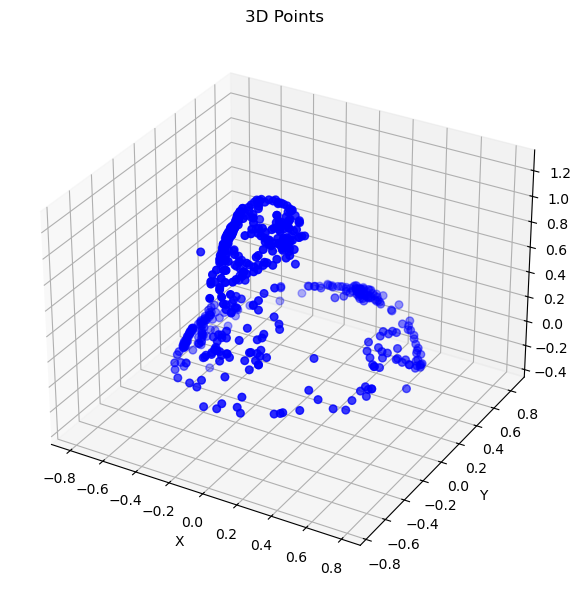

In [138]:
# result = sampler.sample_salient_points(...)
fig, ax = plot_sampled_points(filtered_pts, point_size=30, point_color='blue')

In [60]:
def overlay_saliency_on_rgb(target_rgb: torch.Tensor, saliency_map: torch.Tensor, alpha=0.5):
    # Prepare as above
    if target_rgb.ndim == 4:
        img = target_rgb[0].permute(1, 2, 0).cpu().numpy()
    else:
        img = target_rgb.permute(1, 2, 0).cpu().numpy()
    if saliency_map.ndim == 3:
        sal = saliency_map.mean(0)
    else:
        sal = saliency_map
    sal_np = sal.cpu().numpy()

    # Create side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Left: just the RGB
    ax1.imshow(img)
    ax1.set_title("RGB Image")
    ax1.axis("off")

    # Right: RGB + saliency
    ax2.imshow(img)
    ax2.imshow(sal_np, cmap="jet", alpha=alpha)
    ax2.set_title("RGB + Saliency Overlay")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()


In [61]:
from source.saliency import DinoSaliency
saliency_dino = DinoSaliency(
    device=device,
    preprocess_shape=(shape)
)

Using cache found in /home/mikoviny/.cache/torch/hub/facebookresearch_dino_main


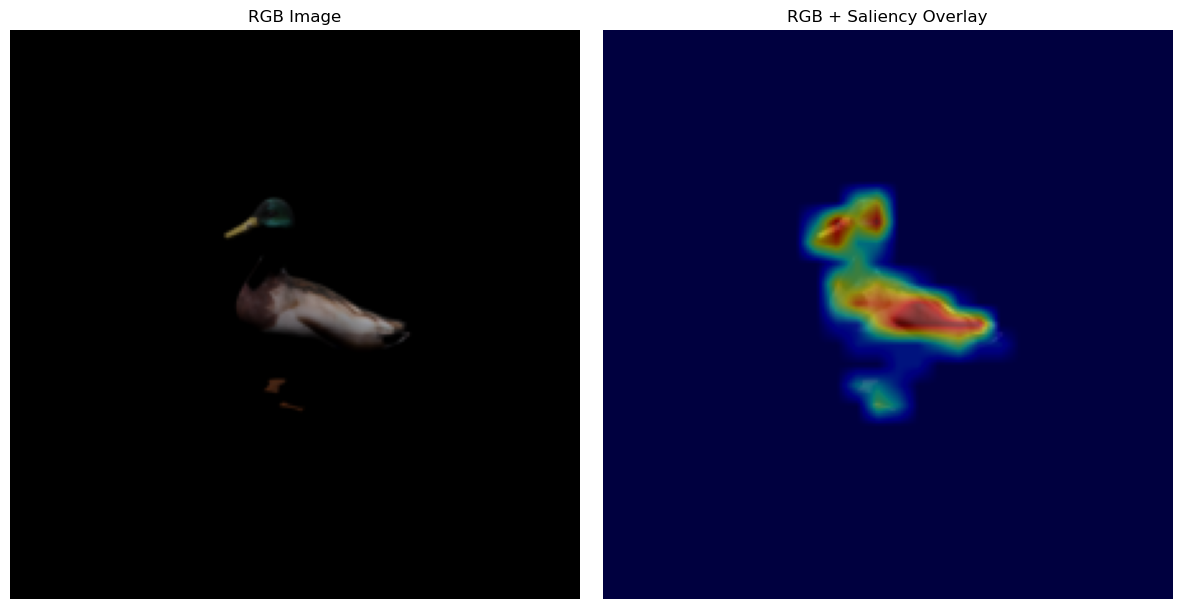

In [88]:
w2c, K, target_rgb, worldpos, frame_idx = sampler.sample()
dino_saliency = saliency_dino.compute(target_rgb, output_size=shape)
overlay_saliency_on_rgb(target_rgb, dino_saliency)

Using cache found in /home/efe/.cache/torch/hub/facebookresearch_dino_main


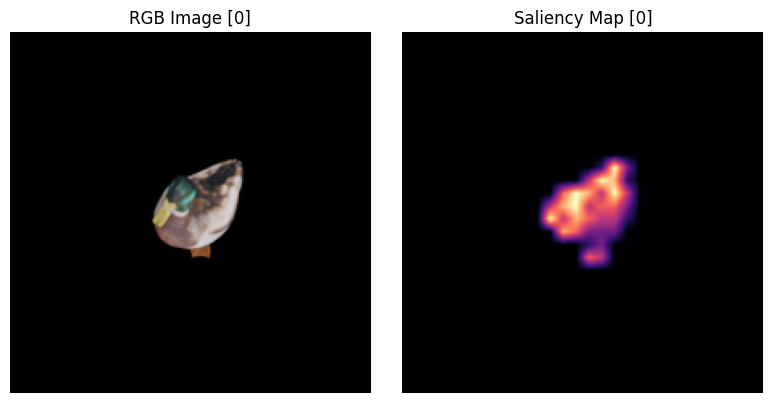

In [21]:
import os
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from source.utils import load_scene
from source.imagesampler import ImageSampler
from source.saliency import DinoSaliency

class SaliencySampler:
    """
    Wraps an ImageSampler to compute and store DINO saliency maps for each view.

    Attributes:
        sampler: ImageSampler instance for RGB + camera data
        saliency_model: pretrained DINO saliency model
        saliency_maps: list of torch.Tensor saliency maps (H, W) per view
        scene_center: 3D center computed from camera poses
    """
    def __init__(
        self,
        transforms_json: str,
        image_dir: str,
        width: int,
        height: int,
        saliency_model: DinoSaliency,
        device: str = "cuda",
    ):
        # initialize underlying image sampler
        self.sampler = ImageSampler(
            transforms_json=transforms_json,
            image_dir=image_dir,
            width=width,
            height=height,
            device=device,
        )
        self.saliency_model = saliency_model
        self.saliency_maps = []

        # compute saliency map for each image
        self._compute_all_saliency()

        # carry over scene center for convenience
        self.scene_center = self.sampler.scene_center

    def _compute_all_saliency(self):
        """Internal: compute and store averaged saliency map per view."""
        to_cpu = lambda t: t.detach().cpu()
        for idx in range(len(self.sampler)):
            rgb, _, _ = self.sampler.sample(idx)
            with torch.no_grad():
                sal = self.saliency_model.compute(
                    img_tensor=rgb,
                    output_size=(rgb.shape[-2], rgb.shape[-1])
                )  # (heads, H, W)
            sal_map = sal.mean(0)  # average heads -> (H, W)
            self.saliency_maps.append(to_cpu(sal_map))

    def __len__(self):
        return len(self.sampler)

    def sample(self, idx: int):
        """
        Returns:
            rgb: torch.Tensor (1,3,H,W)
            K:   torch.Tensor (3,3)
            w2c: torch.Tensor (4,4)
            sal: torch.Tensor (H, W)
        """
        rgb, K, w2c = self.sampler.sample(idx)
        sal = self.saliency_maps[idx]
        return rgb, K, w2c, sal

    def get_saliency_map(self, idx: int) -> torch.Tensor:
        """Return the precomputed saliency map for view idx."""
        return self.saliency_maps[idx]

    def save_saliency_maps(self, out_dir: str, fmt: str = 'png'):
        """
        Save all saliency maps as heatmaps to disk.

        Args:
            out_dir: directory to write images
            fmt:    image format, e.g. 'png'
        """
        os.makedirs(out_dir, exist_ok=True)
        import matplotlib.pyplot as plt
        for i, sal in enumerate(self.saliency_maps):
            plt.imsave(
                os.path.join(out_dir, f"saliency_{i:04d}.{fmt}"),
                sal.numpy(), cmap='magma'
            )

    def plot(self, idx: int):
        """
        Plots the RGB image and its corresponding saliency map side by side.

        Args:
            idx: index of the view to plot

        Returns:
            fig, (ax_img, ax_sal): Matplotlib Figure and Axes tuple
        """
        import matplotlib.pyplot as plt
        rgb, _, _, sal = self.sample(idx)
        img_np = rgb[0].permute(1, 2, 0).cpu().numpy()
        sal_np = sal.cpu().numpy()

        fig, (ax_img, ax_sal) = plt.subplots(1, 2, figsize=(8, 4))
        ax_img.imshow(img_np)
        ax_img.set_title(f"RGB Image [{idx}]")
        ax_img.axis('off')

        im = ax_sal.imshow(sal_np, cmap='magma')
        ax_sal.set_title(f"Saliency Map [{idx}]")
        ax_sal.axis('off')

        plt.tight_layout()
        plt.show()
        return None

device = 'cuda' if torch.cuda.is_available() else 'cpu'
sal_model = DinoSaliency(device=device, preprocess_shape=(224, 224))
sal_sampler = SaliencySampler(
    transforms_json='../data/duck/transforms_train.json',
    image_dir='../data/duck/rgb',
    width=224, height=224,
    saliency_model=sal_model,
    device=device
)
sal_sampler.plot(0)

In [61]:
import os
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from source.utils import load_scene
from source.imagesampler import ImageSampler
from source.saliency import DinoSaliency

class SaliencySampler:
    """
    Wraps an ImageSampler to compute and store DINO saliency maps and select top points per view.

    Attributes:
        sampler: ImageSampler instance
        saliency_model: DinoSaliency model
        saliency_maps: list of torch.Tensor (H, W) saliency maps
        salient_points: list of List[(x, y)] selected pixel coords per view
        scene_center: 3D center from camera poses
        num_points: points requested per view
        min_distance: minimum pixel distance between selected points
        high_threshold: minimum saliency value to consider
    """
    def __init__(
        self,
        transforms_json: str,
        image_dir: str,
        width: int,
        height: int,
        saliency_model: DinoSaliency,
        num_points: int,
        min_distance: float,
        high_threshold: float = 0.0,
        device: str = "cuda",
    ):
        # store configuration
        self.num_points = num_points
        self.min_distance = min_distance
        self.high_threshold = high_threshold
        # initialize underlying sampler
        self.sampler = ImageSampler(
            transforms_json=transforms_json,
            image_dir=image_dir,
            width=width,
            height=height,
            device=device,
        )
        self.saliency_model = saliency_model
        self.saliency_maps = []
        self.salient_points = []

        # compute saliency and select points for each frame
        self._compute_all_saliency()

        # scene center passthrough
        self.scene_center = self.sampler.scene_center

    def _compute_all_saliency(self):
        """Internal: compute saliency and select top points, printing progress."""
        N = len(self.sampler)
        to_cpu = lambda t: t.detach().cpu()
        for idx in range(N):
            rgb, _, _ = self.sampler.sample(idx)
            # saliency inference
            with torch.no_grad():
                sal = self.saliency_model.compute(
                    img_tensor=rgb,
                    output_size=(rgb.shape[-2], rgb.shape[-1])
                )  # (heads, H, W)
            sal_map = sal.mean(0)  # (H, W)
            sal_map_cpu = to_cpu(sal_map)
            self.saliency_maps.append(sal_map_cpu)
            # select salient points above threshold
            pts = self.sample_salient_points(
                idx,
                num_points=self.num_points,
                min_distance=self.min_distance,
                threshold=self.high_threshold
            )
            self.salient_points.append(pts)
            print(f"Processed frame {idx+1}/{N}: selected {len(pts)}/{self.num_points} points")

    def __len__(self):
        return len(self.sampler)

    def sample(self, idx: int):
        """
        Returns: rgb, K, w2c, sal_map, points for view idx.
        """
        rgb, K, w2c = self.sampler.sample(idx)
        sal = self.saliency_maps[idx]
        pts = self.salient_points[idx]
        return rgb, K, w2c, sal, pts

    def get_saliency_map(self, idx: int) -> torch.Tensor:
        return self.saliency_maps[idx]

    def save_saliency_maps(self, out_dir: str, fmt: str = 'png'):
        os.makedirs(out_dir, exist_ok=True)
        import matplotlib.pyplot as plt
        for i, sal in enumerate(self.saliency_maps):
            plt.imsave(
                os.path.join(out_dir, f"saliency_{i:04d}.{fmt}"),
                sal.numpy(), cmap='magma'
            )

    def sample_salient_points(
        self,
        idx: int,
        num_points: int = None,
        min_distance: float = None,
        threshold: float = None
    ):
        """
        Pick up to num_points with highest saliency, enforcing pixel min_distance
        and saliency >= threshold.

        Args:
            idx: view index
            num_points: max points
            min_distance: min pixel L2 distance
            threshold: min saliency value
        Returns:
            List[(x,y)] of selected coords
        """
        if num_points is None:
            num_points = self.num_points
        if min_distance is None:
            min_distance = self.min_distance
        if threshold is None:
            threshold = self.high_threshold
        sal = self.saliency_maps[idx]
        H, W = sal.shape
        flat = sal.flatten()
        # indices above threshold
        valid_inds = (flat >= threshold).nonzero(as_tuple=True)[0]
        # sort valid by saliency
        sorted_inds = valid_inds[torch.argsort(flat[valid_inds], descending=True)].tolist()
        selected = []
        for ind in sorted_inds:
            y = ind // W
            x = ind % W
            # enforce distance
            too_close = False
            for (x0, y0) in selected:
                if (x - x0)**2 + (y - y0)**2 < min_distance**2:
                    too_close = True
                    break
            if not too_close:
                selected.append((x, y))
                if len(selected) >= num_points:
                    break
        return selected

    def plot(self, idx: int):
        """
        Plot RGB with overlayed points and saliency heatmap side by side.
        """
        import matplotlib.pyplot as plt
        rgb, _, _, sal, pts = self.sample(idx)
        img_np = rgb[0].permute(1, 2, 0).cpu().numpy()
        sal_np = sal.cpu().numpy()
        fig, (ax_img, ax_sal) = plt.subplots(1, 2, figsize=(8, 4))
        # show image
        ax_img.imshow(img_np)
        ax_img.set_title(f"RGB [{idx}]")
        ax_img.axis('off')
        # overlay points
        if pts:
            xs, ys = zip(*pts)
            ax_img.scatter(xs, ys, s=20, c='cyan', marker='o')
        # show saliency
        im = ax_sal.imshow(sal_np, cmap='magma')
        ax_sal.set_title(f"Saliency [{idx}]")
        ax_sal.axis('off')
        fig.colorbar(im, ax=ax_sal, fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
        return fig, (ax_img, ax_sal)

sal_sampler = SaliencySampler(
    transforms_json = '../data/duck/transforms_train.json',
    image_dir = '../data/duck/rgb',
    height=224, 
    width=224,
    num_points=50,
    saliency_model=DinoSaliency(device=device, preprocess_shape=(224, 224)),
    min_distance=5.0,
    high_threshold=0.4
)


Using cache found in /home/efe/.cache/torch/hub/facebookresearch_dino_main


Processed frame 1/97: selected 50/50 points
Processed frame 2/97: selected 47/50 points
Processed frame 3/97: selected 50/50 points
Processed frame 4/97: selected 46/50 points
Processed frame 5/97: selected 50/50 points
Processed frame 6/97: selected 50/50 points
Processed frame 7/97: selected 50/50 points
Processed frame 8/97: selected 50/50 points
Processed frame 9/97: selected 50/50 points
Processed frame 10/97: selected 38/50 points
Processed frame 11/97: selected 50/50 points
Processed frame 12/97: selected 50/50 points
Processed frame 13/97: selected 50/50 points
Processed frame 14/97: selected 41/50 points
Processed frame 15/97: selected 50/50 points
Processed frame 16/97: selected 50/50 points
Processed frame 17/97: selected 50/50 points
Processed frame 18/97: selected 39/50 points
Processed frame 19/97: selected 50/50 points
Processed frame 20/97: selected 50/50 points
Processed frame 21/97: selected 50/50 points
Processed frame 22/97: selected 50/50 points
Processed frame 23/

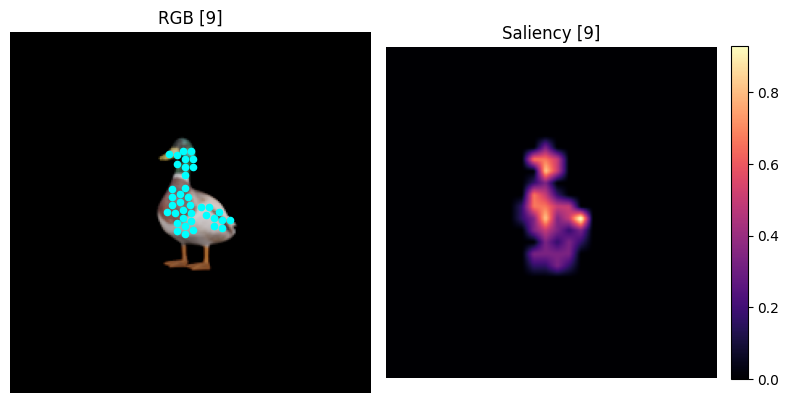

(<Figure size 800x400 with 3 Axes>,
 (<Axes: title={'center': 'RGB [9]'}>,
  <Axes: title={'center': 'Saliency [9]'}>))

In [64]:
sal_sampler.plot(9)

In [106]:
import os
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from source.utils import load_scene
from source.imagesampler import ImageSampler
from source.saliency import DinoSaliency

class SaliencySampler:
    """
    Wraps an ImageSampler to compute and store DINO saliency maps, select top points per view,
    project them onto a sphere, and visualize them in 2D and 3D.

    Attributes:
        sampler: ImageSampler instance
        saliency_model: DinoSaliency model
        saliency_maps: list of torch.Tensor (H, W) saliency maps
        salient_points: list of List[(x, y)] selected pixel coords per view
        scene_center: 3D center from camera poses
        num_points: points requested per view
        min_distance: minimum pixel distance between selected points
        high_threshold: minimum saliency value to consider
    """
    def __init__(
        self,
        transforms_json: str,
        image_dir: str,
        width: int,
        height: int,
        saliency_model: DinoSaliency,
        num_points: int,
        min_distance: float,
        high_threshold: float = 0.0,
        device: str = "cuda",
    ):
        # store configuration
        self.num_points = num_points
        self.min_distance = min_distance
        self.high_threshold = high_threshold
        # initialize underlying sampler
        self.sampler = ImageSampler(
            transforms_json=transforms_json,
            image_dir=image_dir,
            width=width,
            height=height,
            device=device,
        )
        self.saliency_model = saliency_model
        self.saliency_maps = []
        self.salient_points = []

        # compute saliency and select points for each frame
        self._compute_all_saliency()

        # scene center passthrough
        self.scene_center = self.sampler.scene_center

    def _compute_all_saliency(self):
        """Internal: compute saliency and select top points, printing progress."""
        N = len(self.sampler)
        to_cpu = lambda t: t.detach().cpu()
        for idx in range(N):
            rgb, _, _ = self.sampler.sample(idx)
            with torch.no_grad():
                sal = self.saliency_model.compute(
                    img_tensor=rgb,
                    output_size=(rgb.shape[-2], rgb.shape[-1])
                )  # (heads, H, W)
            sal_map = sal.mean(0)
            sal_map_cpu = to_cpu(sal_map)
            self.saliency_maps.append(sal_map_cpu)
            pts = self.sample_salient_points(
                idx,
                num_points=self.num_points,
                min_distance=self.min_distance,
                threshold=self.high_threshold
            )
            self.salient_points.append(pts)
            print(f"Processed frame {idx+1}/{N}: selected {len(pts)}/{self.num_points} points")

    def __len__(self):
        return len(self.sampler)

    def sample(self, idx: int):
        """Returns: rgb, K, w2c, sal_map, points for view idx."""
        rgb, K, w2c = self.sampler.sample(idx)
        sal = self.saliency_maps[idx]
        pts = self.salient_points[idx]
        return rgb, K, w2c, sal, pts

    def get_saliency_map(self, idx: int) -> torch.Tensor:
        return self.saliency_maps[idx]

    def save_saliency_maps(self, out_dir: str, fmt: str = 'png'):
        os.makedirs(out_dir, exist_ok=True)
        import matplotlib.pyplot as plt
        for i, sal in enumerate(self.saliency_maps):
            plt.imsave(
                os.path.join(out_dir, f"saliency_{i:04d}.{fmt}"),
                sal.numpy(), cmap='magma'
            )

    def sample_salient_points(
        self,
        idx: int,
        num_points: int = None,
        min_distance: float = None,
        threshold: float = None
    ):
        """Pick up to num_points with highest saliency, enforcing pixel distance and threshold."""
        if num_points is None:
            num_points = self.num_points
        if min_distance is None:
            min_distance = self.min_distance
        if threshold is None:
            threshold = self.high_threshold
        sal = self.saliency_maps[idx]
        H, W = sal.shape
        flat = sal.flatten()
        valid_inds = (flat >= threshold).nonzero(as_tuple=True)[0]
        sorted_inds = valid_inds[torch.argsort(flat[valid_inds], descending=True)].tolist()
        selected = []
        for ind in sorted_inds:
            y = ind // W
            x = ind % W
            too_close = any((x-x0)**2 + (y-y0)**2 < min_distance**2 for x0,y0 in selected)
            if not too_close:
                selected.append((x, y))
                if len(selected) >= num_points:
                    break
        return selected

    def project_to_sphere(
        self,
        idx: int,
        radius: float
    ) -> list:
        """Project selected 2D points for view idx onto a sphere of given radius by direction projection."""
        # sample returns rgb, K, w2c, sal_map, pts
        _, K, w2c, sal_map, pts = self.sample(idx)
        device = K.device
        # invert world-to-camera to get camera-to-world
        c2w = torch.linalg.inv(w2c)
        # intrinsics inverse
        K_inv = torch.linalg.inv(K)
        # sphere center
        center = torch.from_numpy(self.scene_center).to(device)
        points3d = []
        for (u, v) in pts:
            # compute ray direction in camera coords
            uv1 = torch.tensor([u, v, 1.0], device=device)
            d_cam = -K_inv @ uv1
            d_cam = d_cam / torch.norm(d_cam)
            # ray direction in world coords
            R = c2w[:3, :3]
            d_world = R @ d_cam
            d_world = d_world / torch.norm(d_world)
            # project onto sphere surface from center along ray direction
            P = center + radius * d_world
            points3d.append((P[0].item(), P[1].item(), P[2].item()))
        # store for later
        self.points3d = points3d
        return points3d

    def plot(self, idx: int):
        """Plot RGB with overlayed 2D points and saliency heatmap side by side."""
        import matplotlib.pyplot as plt
        rgb, _, _, sal, pts = self.sample(idx)
        img_np = rgb[0].permute(1, 2, 0).cpu().numpy()
        sal_np = sal.cpu().numpy()
        fig, (ax_img, ax_sal) = plt.subplots(1, 2, figsize=(8, 4))
        ax_img.imshow(img_np)
        ax_img.set_title(f"RGB [{idx}]")
        ax_img.axis('off')
        if pts:
            xs, ys = zip(*pts)
            ax_img.scatter(xs, ys, s=20, c='cyan', marker='o')
        im = ax_sal.imshow(sal_np, cmap='magma')
        ax_sal.set_title(f"Saliency [{idx}]")
        ax_sal.axis('off')
        fig.colorbar(im, ax=ax_sal, fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
        return fig, (ax_img, ax_sal)

    def plot_3d(self, idx: int, radius: float):
        """Plot the projected 3D salient points for view idx on a sphere."""
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
        pts3d = self.project_to_sphere(idx, radius)
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
        if pts3d:
            arr = np.array(pts3d, dtype=np.float32)
            ax.scatter(arr[:,0], arr[:,1], arr[:,2], s=20, c='magenta', depthshade=True)
        else:
            ax.text(0.5, 0.5, 0.5, "No 3D points", ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"3D Salient Points [View {idx}]")
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        # equal aspect
        if pts3d:
            mins = arr.min(axis=0); maxs = arr.max(axis=0)
            mid = (mins + maxs) / 2.0
            r = (maxs - mins).max() / 2.0
            ax.set_xlim(mid[0]-r, mid[0]+r)
            ax.set_ylim(mid[1]-r, mid[1]+r)
            ax.set_zlim(mid[2]-r, mid[2]+r)
        plt.tight_layout()
        plt.show()
        return fig, ax

    def project_all_to_sphere(self, radius: float) -> list:
        """
        Project salient points from all views onto a sphere of given radius.
        Returns a flat list of 3D points.
        """
        all_pts3d = []
        for idx in range(len(self.sampler)):
            pts3d = self.project_to_sphere(idx, radius)
            all_pts3d.extend(pts3d)
        # store for later
        self.all_points3d = all_pts3d
        return all_pts3d

    def plot_all_3d(self, radius: float):
        """
        Plot all projected 3D salient points from every view on a sphere.
        """
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
        pts3d = self.project_all_to_sphere(radius)
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
        if pts3d:
            arr = np.array(pts3d, dtype=np.float32)
            ax.scatter(arr[:,0], arr[:,1], arr[:,2], s=10, c='magenta', depthshade=True)
        else:
            ax.text(0.5, 0.5, 0.5, "No 3D points", ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"3D Salient Points [All Views]")
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        # equal aspect
        if pts3d:
            mins = arr.min(axis=0); maxs = arr.max(axis=0)
            mid = (mins + maxs) / 2.0
            r = (maxs - mins).max() / 2.0
            ax.set_xlim(mid[0]-r, mid[0]+r)
            ax.set_ylim(mid[1]-r, mid[1]+r)
            ax.set_zlim(mid[2]-r, mid[2]+r)
        plt.tight_layout()
        plt.show()
        return fig, ax

    def plot_on_sphere(
        self,
        radius: float,
        resolution: int = 30
    ):
        """
        Project and plot all salient points on a transparent 3D sphere centered at scene_center.

        Args:
            radius: sphere radius
            resolution: sphere mesh resolution (number of segments)
        Returns:
            fig, ax: Matplotlib 3D figure and axis
        """
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
        # compute all 3D points
        pts3d = self.project_all_to_sphere(radius)
        # sphere center
        center = np.array(self.scene_center, dtype=np.float32)
        # create sphere mesh
        u = np.linspace(0, 2*np.pi, resolution)
        v = np.linspace(0, np.pi, resolution)
        uu, vv = np.meshgrid(u, v)
        x = center[0] + radius * np.cos(uu) * np.sin(vv)
        y = center[1] + radius * np.sin(uu) * np.sin(vv)
        z = center[2] + radius * np.cos(vv)
        # plot
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, projection='3d')
        # transparent sphere
        ax.plot_surface(x, y, z, color='lightgrey', alpha=0.3, rstride=1, cstride=1, linewidth=0)
        # plot points
        if pts3d:
            arr = np.array(pts3d, dtype=np.float32)
            ax.scatter(arr[:,0], arr[:,1], arr[:,2], s=10, c='magenta', depthshade=True)
        else:
            ax.text(center[0], center[1], center[2], "No points", ha='center', va='center')
        ax.set_title('All Salient Points on Sphere')
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        # equal aspect
        if pts3d:
            mins = arr.min(axis=0); maxs = arr.max(axis=0)
            mid = (mins + maxs) / 2.0
            r = (maxs - mins).max() / 2.0
            ax.set_xlim(mid[0]-r, mid[0]+r)
            ax.set_ylim(mid[1]-r, mid[1]+r)
            ax.set_zlim(mid[2]-r, mid[2]+r)
        plt.tight_layout()
        plt.show()
        return fig, ax




In [107]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sal_model = DinoSaliency(device=device, preprocess_shape=(224, 224))
sal_sampler = SaliencySampler(
    transforms_json='../data/duck/transforms_train.json',
    image_dir='../data/duck/rgb',
    width=224, height=224,
    saliency_model=sal_model,
    num_points=10,
    min_distance=5.0,
    high_threshold=0.6,
    device=device
)

Using cache found in /home/efe/.cache/torch/hub/facebookresearch_dino_main


Processed frame 1/97: selected 10/10 points
Processed frame 2/97: selected 10/10 points
Processed frame 3/97: selected 10/10 points
Processed frame 4/97: selected 10/10 points
Processed frame 5/97: selected 10/10 points
Processed frame 6/97: selected 10/10 points
Processed frame 7/97: selected 10/10 points
Processed frame 8/97: selected 10/10 points
Processed frame 9/97: selected 10/10 points
Processed frame 10/97: selected 10/10 points
Processed frame 11/97: selected 10/10 points
Processed frame 12/97: selected 10/10 points
Processed frame 13/97: selected 10/10 points
Processed frame 14/97: selected 10/10 points
Processed frame 15/97: selected 10/10 points
Processed frame 16/97: selected 10/10 points
Processed frame 17/97: selected 10/10 points
Processed frame 18/97: selected 10/10 points
Processed frame 19/97: selected 10/10 points
Processed frame 20/97: selected 10/10 points
Processed frame 21/97: selected 10/10 points
Processed frame 22/97: selected 10/10 points
Processed frame 23/

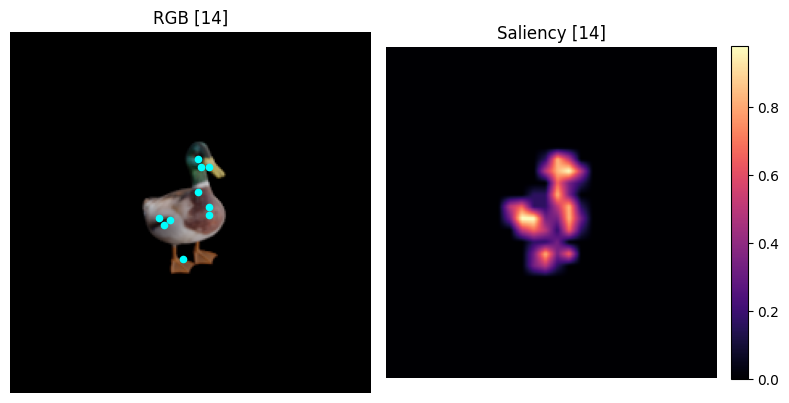

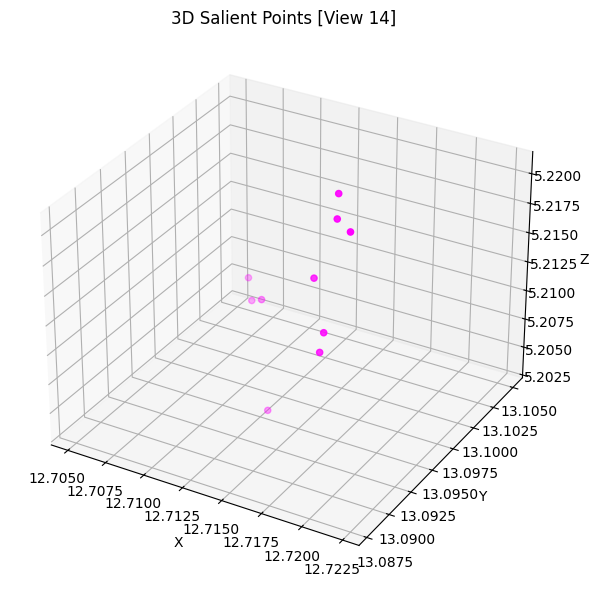

(<Figure size 600x600 with 1 Axes>,
 <Axes3D: title={'center': '3D Salient Points [View 14]'}, xlabel='X', ylabel='Y', zlabel='Z'>)

In [110]:
sal_sampler.plot(idx=14)
sal_sampler.plot_3d(idx = 14,radius=0.1)
